In [1]:
!gdown 1fZdPFOSDy1MKWIIfkTA2WqzTX0m7Lb6E

Downloading...
From (original): https://drive.google.com/uc?id=1fZdPFOSDy1MKWIIfkTA2WqzTX0m7Lb6E
From (redirected): https://drive.google.com/uc?id=1fZdPFOSDy1MKWIIfkTA2WqzTX0m7Lb6E&confirm=t&uuid=4a50ed11-da5e-4173-826f-30aff49efc86
To: /content/fraud_dataset.zip
100% 69.2M/69.2M [00:02<00:00, 25.0MB/s]


In [2]:
!unzip /content/fraud_dataset.zip

Archive:  /content/fraud_dataset.zip
  inflating: creditcard.csv          


In [3]:
import pandas as pd
creditcard_data = pd.read_csv('/content/creditcard.csv')

In [4]:
from sklearn.preprocessing import StandardScaler

# Data Preprocessing
creditcard_data['NormalizedAmount'] = StandardScaler().fit_transform(creditcard_data['Amount'].values.reshape(-1, 1))
creditcard_data = creditcard_data.drop(['Time', 'Amount'], axis=1)

In [5]:
creditcard_data.shape

(284807, 30)

In [6]:
creditcard_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   V1                284807 non-null  float64
 1   V2                284807 non-null  float64
 2   V3                284807 non-null  float64
 3   V4                284807 non-null  float64
 4   V5                284807 non-null  float64
 5   V6                284807 non-null  float64
 6   V7                284807 non-null  float64
 7   V8                284807 non-null  float64
 8   V9                284807 non-null  float64
 9   V10               284807 non-null  float64
 10  V11               284807 non-null  float64
 11  V12               284807 non-null  float64
 12  V13               284807 non-null  float64
 13  V14               284807 non-null  float64
 14  V15               284807 non-null  float64
 15  V16               284807 non-null  float64
 16  V17               28

In [7]:
creditcard_data.isnull().sum()

V1                  0
V2                  0
V3                  0
V4                  0
V5                  0
V6                  0
V7                  0
V8                  0
V9                  0
V10                 0
V11                 0
V12                 0
V13                 0
V14                 0
V15                 0
V16                 0
V17                 0
V18                 0
V19                 0
V20                 0
V21                 0
V22                 0
V23                 0
V24                 0
V25                 0
V26                 0
V27                 0
V28                 0
Class               0
NormalizedAmount    0
dtype: int64

In [8]:
creditcard_data['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

X = creditcard_data.drop(columns='Class', axis=1)
y = creditcard_data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

# Noise & SMOTE

In [8]:
from imblearn.over_sampling import SMOTE
# Oversampling using SMOTE
smote = SMOTE(sampling_strategy=1.0, random_state=14)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [11]:
import numpy as np

# Adding Gaussian noise
noise_factor = 0.2
X_train_noisy = X_train_res + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_res.shape)
X_train_noisy_norez = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# DAE

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

# Building the Denoising Autoencoder
def build_autoencoder(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(input_dim, activation='sigmoid'))
    model.compile(optimizer='adam', loss='mse')
    return model

# Training the Autoencoder
input_dim = X_train_res.shape[1]
autoencoder = build_autoencoder(input_dim)

# Callbacks for early stopping and saving the best model
autoencoder_callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = autoencoder.fit(X_train_noisy, X_train_res,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2,
                callbacks=autoencoder_callbacks)

# Load the best autoencoder model
autoencoder.load_weights('best_autoencoder.h5')

# Denoising the training and test datasets
X_train_denoised = autoencoder.predict(X_train_res)
X_test_denoised = autoencoder.predict(X_test)

Epoch 1/100
1417/1422 [============================>.] - ETA: 0s - loss: 9.5333
Epoch 1: val_loss improved from inf to 23.61897, saving model to best_autoencoder.h5
1422/1422 [==============================] - 15s 4ms/step - loss: 9.5355 - val_loss: 23.6190
Epoch 2/100
  30/1422 [..............................] - ETA: 4s - loss: 9.5461

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1410/1422 [============================>.] - ETA: 0s - loss: 9.4438
Epoch 2: val_loss improved from 23.61897 to 23.60816, saving model to best_autoencoder.h5
1422/1422 [==============================] - 7s 5ms/step - loss: 9.4407 - val_loss: 23.6082
Epoch 3/100
1420/1422 [============================>.] - ETA: 0s - loss: 9.4218
Epoch 3: val_loss improved from 23.60816 to 23.58213, saving model to best_autoencoder.h5
1422/1422 [==============================] - 6s 4ms/step - loss: 9.4228 - val_loss: 23.5821
Epoch 4/100
1421/1422 [============================>.] - ETA: 0s - loss: 9.4091
Epoch 4: val_loss improved from 23.58213 to 23.57450, saving model to best_autoencoder.h5
1422/1422 [==============================] - 7s 5ms/step - loss: 9.4081 - val_loss: 23.5745
Epoch 5/100
1416/1422 [============================>.] - ETA: 0s - loss: 9.4024
Epoch 5: val_loss improved from 23.57450 to 23.57323, saving model to best_autoencoder.h5
1422/1422 [==============================] - 5s 4ms/step

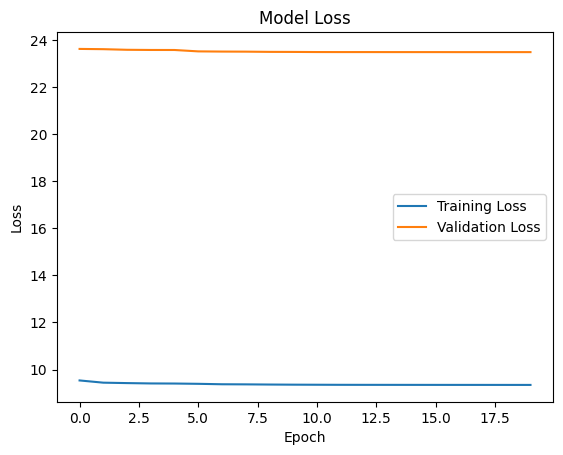

In [13]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# CLF

In [14]:
import keras.backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [15]:
def build_classifier(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', recall_m,precision_m,f1_m])
    return model

classifier = build_classifier(input_dim)

classifier_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_classifier.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = classifier.fit(X_train_denoised, y_train_res,
               epochs=100,
               batch_size=256,
               shuffle=True,
               validation_split=0.2,
               callbacks=classifier_callbacks)


classifier.load_weights('best_classifier.h5')

# Evaluating the Classifier
evaluation = classifier.evaluate(X_test_denoised, y_test)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

Epoch 1/100
1417/1422 [============================>.] - ETA: 0s - loss: 0.1353 - accuracy: 0.9429 - recall_m: 1.0000 - precision_m: 0.3751 - f1_m: 0.5448
Epoch 1: val_loss improved from inf to 0.11564, saving model to best_classifier.h5
1422/1422 [==============================] - 10s 4ms/step - loss: 0.1352 - accuracy: 0.9430 - recall_m: 1.0000 - precision_m: 0.3750 - f1_m: 0.5447 - val_loss: 0.1156 - val_accuracy: 0.9468 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 2/100
  43/1422 [..............................] - ETA: 5s - loss: 0.0793 - accuracy: 0.9694 - recall_m: 1.0000 - precision_m: 0.3745 - f1_m: 0.5444

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1419/1422 [============================>.] - ETA: 0s - loss: 0.0670 - accuracy: 0.9725 - recall_m: 1.0000 - precision_m: 0.3750 - f1_m: 0.5447
Epoch 2: val_loss improved from 0.11564 to 0.08583, saving model to best_classifier.h5
1422/1422 [==============================] - 7s 5ms/step - loss: 0.0670 - accuracy: 0.9724 - recall_m: 1.0000 - precision_m: 0.3750 - f1_m: 0.5447 - val_loss: 0.0858 - val_accuracy: 0.9663 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 3/100
1419/1422 [============================>.] - ETA: 0s - loss: 0.0547 - accuracy: 0.9783 - recall_m: 1.0000 - precision_m: 0.3750 - f1_m: 0.5447
Epoch 3: val_loss improved from 0.08583 to 0.06188, saving model to best_classifier.h5
1422/1422 [==============================] - 6s 4ms/step - loss: 0.0546 - accuracy: 0.9783 - recall_m: 1.0000 - precision_m: 0.3750 - f1_m: 0.5447 - val_loss: 0.0619 - val_accuracy: 0.9794 - val_recall_m: 1.0000 - val_precision_m: 1.0000 - val_f1_m: 1.0000
Epoch 4/100
14

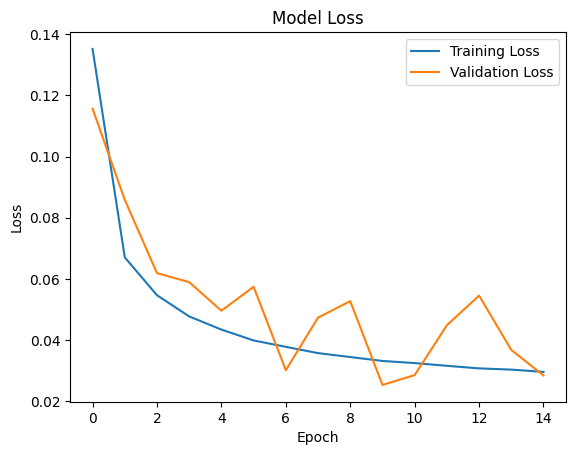

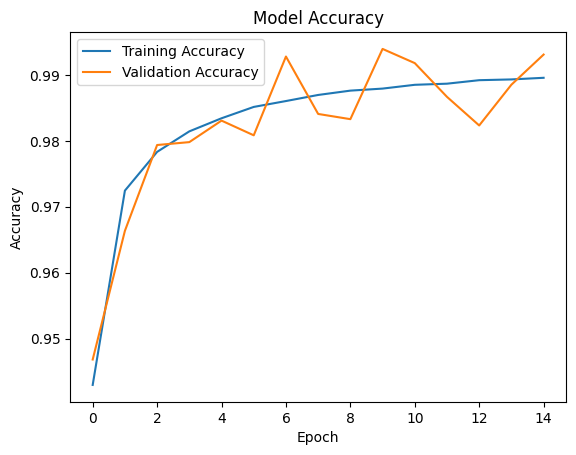

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1781/1781 [==============================] - 3s 1ms/step


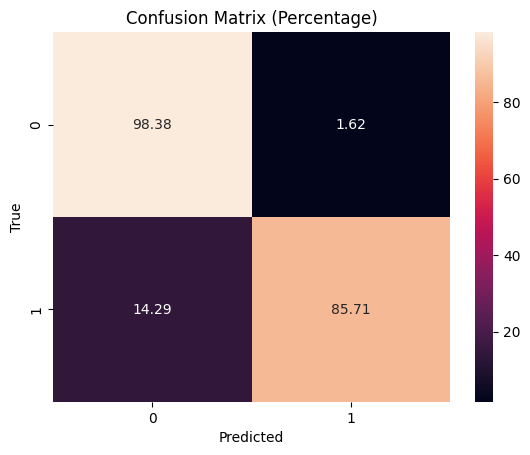

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.08      0.86      0.15        98

    accuracy                           0.98     56962
   macro avg       0.54      0.92      0.57     56962
weighted avg       1.00      0.98      0.99     56962

Test AUC: 0.9204555731972024
Test Recall: 0.9835504371335276
Test F1-score: 0.9835504371335276
Test Precision: 0.9835504371335276


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = classifier.predict(X_test_denoised)
Y_pred_classes = np.round(Y_pred)
Y_pred_bin =np.argmax(Y_pred,axis=1)
cm = confusion_matrix(y_test, Y_pred_bin)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, Y_pred_bin))

# Additional metrics
auc_score = roc_auc_score(y_test, Y_pred_bin, multi_class='ovr')
recall = recall_score(y_test, Y_pred_bin, average='micro')
f1 = f1_score(y_test, Y_pred_bin, average='micro')
precision = precision_score(y_test, Y_pred_bin, average='micro')

print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

## Noisy data

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf

X_train_noisy_norez = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

def build_classifier(input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(22, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

input_dim = X_train_noisy_norez.shape[1]

classifier_noisy = build_classifier(input_dim)

classifier_callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ModelCheckpoint('best_classifier_noisy.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

history = classifier_noisy.fit(X_train_noisy_norez, y_train_res,
               epochs=100,
               batch_size=128,
               shuffle=True,
               validation_split=0.2,
               callbacks=classifier_callbacks)


classifier_noisy.load_weights('best_classifier_noisy.h5')

# Evaluating the Classifier
evaluation = classifier_noisy.evaluate(X_test, y_test)
print(f'Test Accuracy: {evaluation[1] * 100:.2f}%')

Epoch 1/100
1412/1425 [============================>.] - ETA: 0s - loss: 0.0314 - accuracy: 0.9930
Epoch 1: val_loss improved from inf to 0.00366, saving model to best_classifier_noisy.h5
1425/1425 [==============================] - 5s 3ms/step - loss: 0.0312 - accuracy: 0.9931 - val_loss: 0.0037 - val_accuracy: 0.9994
Epoch 2/100
  60/1425 [>.............................] - ETA: 3s - loss: 0.0050 - accuracy: 0.9992

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1419/1425 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9993
Epoch 2: val_loss improved from 0.00366 to 0.00325, saving model to best_classifier_noisy.h5
1425/1425 [==============================] - 6s 4ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.0033 - val_accuracy: 0.9993
Epoch 3/100
1410/1425 [============================>.] - ETA: 0s - loss: 0.0031 - accuracy: 0.9994
Epoch 3: val_loss improved from 0.00325 to 0.00309, saving model to best_classifier_noisy.h5
1425/1425 [==============================] - 8s 6ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 4/100
1424/1425 [============================>.] - ETA: 0s - loss: 0.0030 - accuracy: 0.9994
Epoch 4: val_loss improved from 0.00309 to 0.00307, saving model to best_classifier_noisy.h5
1425/1425 [==============================] - 4s 3ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.0031 - val_accuracy: 0.9994
Epoch 5/100
1424/1425 [==============

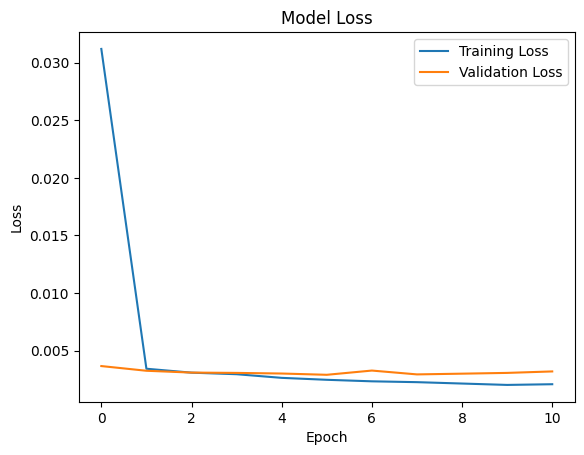

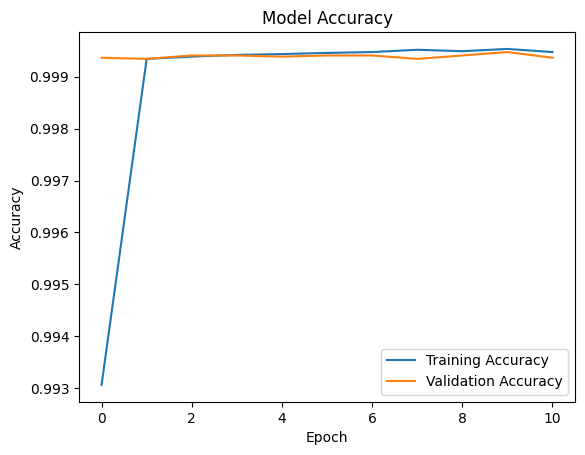

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1781/1781 [==============================] - 5s 3ms/step


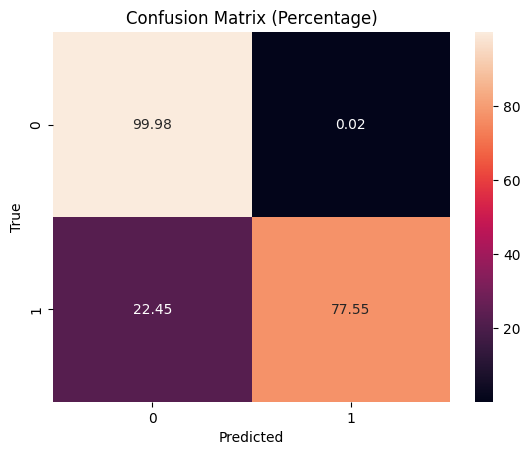

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.78      0.81        98

    accuracy                           1.00     56962
   macro avg       0.93      0.89      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Test AUC: 0.8876407942186441
Test Recall: 0.999385555282469
Test F1-score: 0.999385555282469
Test Precision: 0.999385555282469


In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = classifier_noisy.predict(X_test)
Y_pred_classes = np.round(Y_pred)
Y_pred_bin =np.argmax(Y_pred,axis=1)
cm = confusion_matrix(y_test, Y_pred_bin)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percentage, annot=True, fmt='.2f')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()
from sklearn.metrics import roc_auc_score, recall_score, f1_score, precision_score, classification_report, confusion_matrix
# Print classification report
print(classification_report(y_test, Y_pred_bin))

# Additional metrics
auc_score = roc_auc_score(y_test, Y_pred_bin, multi_class='ovr')
recall = recall_score(y_test, Y_pred_bin, average='micro')
f1 = f1_score(y_test, Y_pred_bin, average='micro')
precision = precision_score(y_test, Y_pred_bin, average='micro')

print('Test AUC:', auc_score)
print('Test Recall:', recall)
print('Test F1-score:', f1)
print('Test Precision:', precision)

# oversampling with different thr

1781/1781 [==============================] - 3s 2ms/step


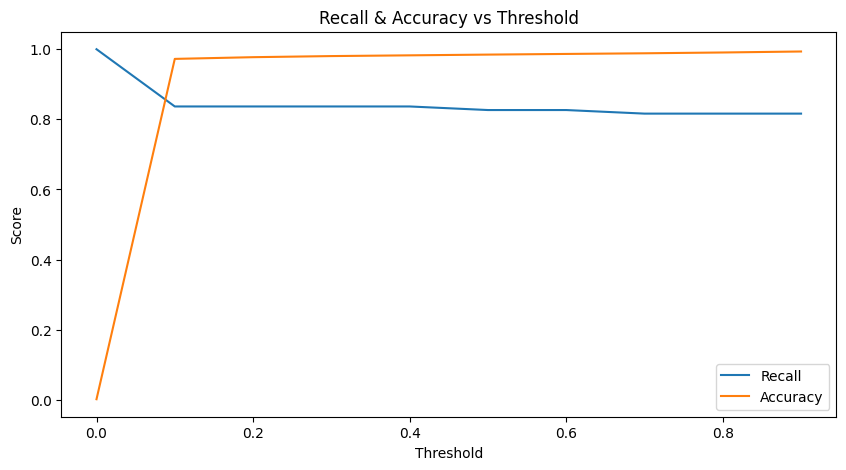

Recalls: [1.0, 0.8367346938775511, 0.8367346938775511, 0.8367346938775511, 0.8367346938775511, 0.826530612244898, 0.826530612244898, 0.8163265306122449, 0.8163265306122449, 0.8163265306122449]
Accuracies: [0.0017204452090867595, 0.9724202099645377, 0.9773006565780696, 0.9804431024191567, 0.98254977002212, 0.9846564376250834, 0.9865524384677504, 0.9883957726203434, 0.9906955514202451, 0.9935219971208876]


In [23]:
from sklearn.metrics import recall_score, accuracy_score

# Define a range of thresholds
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Lists to store recall and accuracy values
recalls = []
accuracies = []

# Iterate over each threshold
for threshold in thresholds:
    # Oversampling using SMOTE with the current threshold
    smote = SMOTE(sampling_strategy=threshold, random_state=14)
    X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

    # Adding Gaussian noise
    noise_factor = 0.2
    X_train_noisy = X_train_res + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train_res.shape)

    # Training the Autoencoder
    autoencoder = build_autoencoder(input_dim)
    autoencoder.fit(X_train_noisy, X_train_res, epochs=100, batch_size=256, shuffle=True, validation_split=0.2, callbacks=autoencoder_callbacks)
    autoencoder.load_weights('best_autoencoder.h5')

    # Denoising the training dataset
    X_train_denoised = autoencoder.predict(X_train_res)

    # Training the Classifier
    classifier = build_classifier(input_dim)
    classifier.fit(X_train_denoised, y_train_res, epochs=100, batch_size=256, shuffle=True, validation_split=0.2, callbacks=classifier_callbacks)
    classifier.load_weights('best_classifier.h5')

    # Denoising the test dataset
    X_test_denoised = autoencoder.predict(X_test)

    # Evaluating the Classifier
    y_pred = classifier.predict(X_test_denoised)
    y_pred = np.argmax(y_pred, axis=1)

    # Calculating recall and accuracy
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Appending to the lists
    recalls.append(recall)
    accuracies.append(accuracy)

# Plotting the Recall & Accuracy graph
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, accuracies, label='Accuracy', marker='x')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall & Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()